I'll be trying to use a VGG16 (and some others) using Transfer learning to try and recognise the faces of my 109 mangaset!

In [31]:
###### Voor Tensorflow-GPU ########
import tensorflow as tf 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from keras.applications import VGG16
rows = 100
cols = 100

model = VGG16(weights = 'imagenet', include_top = False, input_shape = (rows, cols, 3))

for layer in model.layers:
    layer.trainable = False

for (i,layer) in enumerate(model.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [32]:
def addlayer(bottom_model, num_classes):
    """creates the head of the model that will bw placed on top of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [33]:
model.input

<tf.Tensor 'input_4:0' shape=(None, 100, 100, 3) dtype=float32>

In [34]:
model.layers

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

directory = r'D:\RESEARCH PROJECT\Data\manga109_faces_by_name\train'
files = os.listdir(directory)

num_classes = len(files)

print(num_classes)

FC_Head = addlayer(model, num_classes)
modelnew = Model(inputs=model.input, outputs=FC_Head)
print(modelnew.summary())

222
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       

In [37]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = (r'D:\RESEARCH PROJECT\Data\manga109_faces_by_name/train')
validation_data_dir = (r'D:\RESEARCH PROJECT\Data\manga109_faces_by_name/val')


train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 15
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(rows, cols),
                                                    batch_size=train_batchsize,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                    target_size=(rows, cols),
                                                    batch_size=val_batchsize,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 9642 images belonging to 222 classes.
Found 6639 images belonging to 222 classes.


In [41]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("face_recog_vgg.h5", monitor="val_loss", mode="min", save_best_only = True, verbose=1)
# earlystop = EarlyStopping(monitor= 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)
callbacks = [checkpoint]

modelnew.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001),metrics=['accuracy'])

nb_train_samples=180
nb_validation_samples=100 
epochs=10000
batch_size=64

history = modelnew.fit(train_generator,
                                 steps_per_epoch=nb_train_samples // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks,
                                 validation_data=validation_generator,
                                 validation_steps=nb_validation_samples // batch_size)
modelnew.save("face_recog_vgg.h5")

Epoch 1/10000
2/2 [==============================] - ETA: 0s - loss: 4.3336 - accuracy: 0.0667
Epoch 00001: val_loss improved from inf to 4.51094, saving model to face_recog_vgg.h5
2/2 [==============================] - 1s 683ms/step - loss: 4.3336 - accuracy: 0.0667 - val_loss: 4.5109 - val_accuracy: 0.0000e+00
Epoch 2/10000
2/2 [==============================] - ETA: 0s - loss: 3.6726 - accuracy: 0.1667
Epoch 00002: val_loss improved from 4.51094 to 2.62957, saving model to face_recog_vgg.h5
2/2 [==============================] - 1s 493ms/step - loss: 3.6726 - accuracy: 0.1667 - val_loss: 2.6296 - val_accuracy: 0.4000
Epoch 3/10000
2/2 [==============================] - ETA: 0s - loss: 2.6927 - accuracy: 0.4333
Epoch 00003: val_loss improved from 2.62957 to 2.28869, saving model to face_recog_vgg.h5
2/2 [==============================] - 1s 380ms/step - loss: 2.6927 - accuracy: 0.4333 - val_loss: 2.2887 - val_accuracy: 0.4000
Epoch 4/10000
2/2 [==============================] - ETA: 

KeyboardInterrupt: 

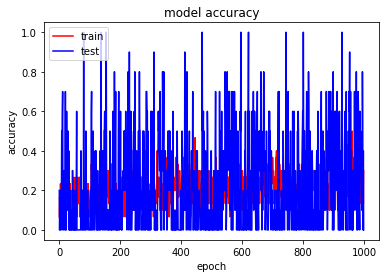

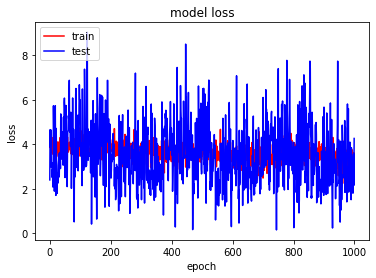

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()